<a href="https://colab.research.google.com/github/zktuong/dandelion/blob/devel/dandelion_singularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to `dandelion`
<img src='https://github.com/zktuong/dandelion/blob/master/docs/notebooks/img/dandelion_logo_illustration.png?raw=true' />

## **Set up**

On top of installing `dandelion`, we will set up `singularity` for running the preprocessing as it requires several non-python softwares and database dependencies that are easily taken care of by the container. Please be patient as the following steps will take ~10-15 mins.

In [1]:
%%time
## set up singularity
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get -qq update && sudo apt-get install build-essential libssl-dev uuid-dev libgpgme11-dev squashfs-tools libseccomp-dev pkg-config -qq > /dev/null
!export VERSION=1.13 OS=linux ARCH=amd64 && wget -q https://dl.google.com/go/go$VERSION.$OS-$ARCH.tar.gz && sudo tar -C /usr/local -xzf go$VERSION.$OS-$ARCH.tar.gz && rm go$VERSION.$OS-$ARCH.tar.gz
!if [ ! -d "singularity" ]; then git clone https://github.com/sylabs/singularity.git -q; fi
!export GOPATH=${HOME}/go && export PATH=/usr/local/go/bin:${PATH}:${GOPATH}/bin && cd singularity && git checkout -q v3.6.1 && ./mconfig >/dev/null 2>/dev/null && make -C ./builddir >/dev/null 2>/dev/null && sudo make -C ./builddir install >/dev/null 2>/dev/null
# Download the `dandelion` singularity image
!if [ ! -e "sc-dandelion_latest.sif" ]; then singularity -s pull library://kt16/default/sc-dandelion:latest; fi

CPU times: user 1.94 s, sys: 265 ms, total: 2.21 s
Wall time: 5min 46s


In [2]:
%%time
## set up python environment with conda
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -q -c conda-forge scanpy python-igraph leidenalg
!python -m pip install -q scrublet "annoy==1.16.3" "scikit-bio==0.5.6" sc-dandelion cffi -U

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...
Solving environment: ...working... 
  - conda-forge/noarch::decorator-5.1.1-pyhd8ed1ab_0, conda-forge/noarch::networkx-2.3-py_0
  - conda-forge/noarch::decorator-4.4.2-py_0, conda-forge/noarch::networkx-2.5.1-pyhd8ed1ab_0done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - leidenalg
    - python-igraph
    - scanpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alabaster-0.7.12           |             py_0          15 KB  conda-forge
    anndata-0.8.0              |   py37h89c1867_0         150 KB  conda-forge
    arpack-3.7.0               |       hdefa2d7_2         215 KB  conda-forge
    babel-2.9.1                |     p

Normally, to check whether everything is set up properly, the following command will print out the help message from the preprocessing script in the container:

```bash
singularity run -B $PWD sc-dandelion_latest.sif dandelion-preprocess --help
```

However, in order to mount the container in this google colab notebook, we have to add an additional step to convert it into sandbox mode and install `ipykernel`. Also, ignore any `LD_PRELOAD` error message that appears throughout later.

In [3]:
# Convert to sandbox mode to make it work for google colab notebook
!sudo singularity build --sandbox sc-dandelion_latest sc-dandelion_latest.sif && singularity -s exec -u -B $PWD sc-dandelion_latest pip install ipykernel -q

INFO:    Starting build...
INFO:    Creating sandbox directory...
INFO:    Build complete: sc-dandelion_latest
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Now to check if everything is set up properly:

In [4]:
# Note: I'm calling the sandbox directory rather than the .sif image file
!singularity run -u -B $PWD sc-dandelion_latest dandelion-preprocess --help

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
Software versions:

dandelion==0.2.0 pandas==1.4.1 numpy==1.21.5 matplotlib==3.5.1 networkx==2.7.1 scipy==1.8.0 skbio==0.5.6
usage: dandelion_preprocess.py
       [-h]
       [--meta META]
       [--chain CHAIN]
       [--file_prefix FILE_PREFIX]
       [--sep SEP]
       [--flavour FLAVOUR]
       [--skip_format_header]
       [--filter_to_high_confidence]
       [--skip_reassign_dj]
       [--keep_trailing_hyphen_n

## **Download example datasets from 10x**

In [5]:
!if [ ! -d "/content/example/sc5p_v2_hs_B_prevax" ]; then mkdir -p /content/example/sc5p_v2_hs_B_prevax; fi
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_count_filtered_feature_bc_matrix.h5
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_vdj_b_filtered_contig.fasta
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_vdj_b_filtered_contig_annotations.csv

!if [ ! -d "/content/example/sc5p_v2_hs_B_postvax" ]; then mkdir -p /content/example/sc5p_v2_hs_B_postvax; fi
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_count_filtered_feature_bc_matrix.h5
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_vdj_b_filtered_contig.fasta
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_vdj_b_filtered_contig_annotations.csv

# trim to just 5000 contigs to make this tutorial shorter
!cd /content/example/sc5p_v2_hs_B_prevax && head -10000 filtered_contig.fasta > filtered_5k_contig.fasta && sed -i '1,+9999d' filtered_contig.fasta && head -5001 filtered_contig_annotations.csv > filtered_5k_contig_annotations.csv && sed -i '1,+5000d' filtered_contig_annotations.csv
!cd /content/example/sc5p_v2_hs_B_postvax && head -10000 filtered_contig.fasta > filtered_5k_contig.fasta && sed -i '1,+9999d' filtered_contig.fasta && head -5001 filtered_contig_annotations.csv > filtered_5k_contig_annotations.csv && sed -i '1,+5000d' filtered_contig_annotations.csv

## **Preprocessing 10x outputs**

As there are two folders to process, we will create a `.csv` file for the `--meta` option that tells the script which folders (`sample_id`) to run the preprocessing, whether to append any `prefix`/`suffix`, and whether the folders belong to a particular `individual` (for [TIgGER](https://tigger.readthedocs.io/)).

In [6]:
import pandas as pd
meta = pd.DataFrame([['sc5p_v2_hs_B_prevax', 'prevax', 'sc5p_v2'], 
                     ['sc5p_v2_hs_B_postvax', 'postvax', 'sc5p_v2']], 
                    columns = ['sample_id', 'prefix', 'individual'])
meta.to_csv('/content/example/meta.csv', index = False)
meta

,sample_id,prefix,individual
0,sc5p_v2_hs_B_prevax,prevax,sc5p_v2
1,sc5p_v2_hs_B_postvax,postvax,sc5p_v2


And now to actually run the preprocessing. The number of input contigs and `cpus` available determine how fast this step completes. In this google colab notebook, it typically takes ~15 min to process the two folders.

In [7]:
%%time
!cd /content/example && singularity run -u -B $PWD ../sc-dandelion_latest dandelion-preprocess \
  --meta meta.csv \
  --chain IG \
  --file_prefix filtered_5k \
  --keep_trailing_hyphen_number

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
Software versions:

dandelion==0.2.0 pandas==1.4.1 numpy==1.21.5 matplotlib==3.5.1 networkx==2.7.1 scipy==1.8.0 skbio==0.5.6

Beginning preprocessing

command line parameters:
: 
--------------------------------------------------------------
    --meta = meta.csv
    --chain = ig
    --file_prefix = filtered_5k
    --sep = _
    --flavour = strict
    --skip_format_header = False
    --filter_to_high_confidence = False
    --keep_trailing_hyphen_number = True
    --skip_reassign_dj = False
    --clean_output = False
--------------------------------------------------------------

Formating fasta(s) : 100% 2/2 [00:00<00:00,  6.09it/s]
Assigning genes :   0% 0/2 [00:00<?, ?it/s]ERROR: ld.so: object '/usr

And now we have a processed output (`filtered_5k_contig_dandelion.tsv`) in each folder that can be used for downstream exploration.

### Import the transcriptome data

In [1]:
import scanpy as sc
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [2]:
adatas = []
for sample in ['prevax', 'postvax']:
  adata = sc.read_10x_h5('/content/example/sc5p_v2_hs_B_'+sample+'/filtered_feature_bc_matrix.h5')
  adata.var_names_make_unique()
  adata.obs_names = [sample + '_' + o for o in adata.obs_names]
  adata.obs['sample_id'] = sample
  adatas.append(adata)
adata = sc.concat(adatas)
adata

/usr/local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 18115 × 36601
    obs: 'sample_id'

### Filter cells that are potental doublets and poor quality in both the V(D)J data and transcriptome data

We use the function `pp.filter_contigs` to mark and filter out cells and contigs from both the V(D)J data and transcriptome data in `AnnData`.

In [3]:
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.2.0 pandas==1.3.5 numpy==1.21.6 matplotlib==3.2.2 networkx==2.6.3 scipy==1.7.3 skbio==0.5.6


In [4]:
import pandas as pd
# first we read in the 2 processed files
bcr_files = []
for sample in ['prevax', 'postvax']:
    file_location = '/content/example/sc5p_v2_hs_B_'+sample+'/dandelion/filtered_5k_contig_dandelion.tsv'
    bcr_files.append(pd.read_csv(file_location, sep = '\t'))
bcr = bcr_files[0].append(bcr_files[1])
bcr.reset_index(inplace = True, drop = True)
bcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,fwr4_aa,cdr1_aa,cdr2_aa,cdr3_aa,sequence_alignment_aa,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa,mu_count,mu_freq
0,prevax_AAACCTGAGAGACGAA-1_contig_2,AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,F,T,"IGHV3-23*01,IGHV3-23D*01",IGHD5-24*01,IGHJ4*02,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCCGCTACCCTAGGGACCCGTAGAGATGGTTACAATTTTGCAT...,...,WGQETLVTVSS,GVTFNSYA,ISGSGANT,AATLGTRRDGYNFAY,EVQLLESGGGLVQPGGSLRLSCAASGVTFNSYAMSWVRQAPGKGLE...,EVQLLESGGGLVQPGGSLRLSCAASGVTFNSYAMSWVRQAPGKGLE...,RDGYN,YWGQETLVTVSS,7,0.021472
1,prevax_AAACCTGAGAGACGAA-1_contig_1,GCCTGGGTCAGAGCTCTGGGGAGGAACTGCTCACTTAGGACCCAGA...,F,T,IGKV3-15*01,NaN,IGKJ4*01,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCGG...,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCAG...,TGTCAGCAGTATAATAACTGGCCTCTCACTTTC,...,FGGGTKVEIK,QSVSSN,GAS,QQYNNWPLT,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQHKPGQAPRL...,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQHKPGQAPRL...,NaN,TFGGGTKVEIK,2,0.006231
2,prevax_AAACCTGAGCGCCTTG-1_contig_1,GATCAGGACTCCTCAGTTCACCTTCTCACAATGAGGCTCCCTGCTC...,F,T,IGKV2-30*01,NaN,IGKJ3*01,GATGTTGTGATGACTCAGTCTCCACTCTCCCTGCCCGTCACCCTTG...,GATGTTGTGATGACTCAGTCTCCACTCTCCCTGCCCGTCACCCTTG...,TGCATGCAAGGTACACACTGGCGTTTCACTTTC,...,FGPGTKVDIK,QSLVYSDGNTY,KVS,MQGTHWRFT,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,NaN,FTFGPGTKVDIK,2,0.005988
3,prevax_AAACCTGAGCGCCTTG-1_contig_2,CGAGCCCAGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCAGC...,F,T,"IGHV3-30*04,IGHV3-30-3*03",NaN,IGHJ3*02,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...,TGTGCGAGTTTCGACTACCATAGTGCTTTTGATATCTGG,...,WGQGTMVTVSS,GFTFSTYD,ISYDGSNK,ASFDYHSAFDI,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTYDMHWVRQAPGEGLE...,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTYDMHWVRQAPGEGLE...,NaN,AFDIWGQGTMVTVSS,8,0.023599
4,prevax_AAACCTGAGTGAACAT-1_contig_2,AGCTCTGGGAGAAGAGCCCCAGCCGCAGATTTCCCAGGAGTTTCCA...,F,T,IGHV3-11*01,"IGHD3-3*01,IGHD3/OR15-3a*01,IGHD3/OR15-3b*01",IGHJ6*02,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTCAAGCCTG...,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTCAAGCCTG...,TGTGCGCGAGATGGTTATTATGATTTTTGGAGTGGTAAATCAGATT...,...,WGQGTTVIVSS,GFSLNDYY,IDNVGTTT,ARDGYYDFWSGKSDYYYGMDL,QVQLVESGGGLVKPGGSLKLSCAASGFSLNDYYMTWIRQPPGKGLQ...,QVQLVESGGGLVKPGGSLKLSCAASGFSLNDYYMTWIRQPPGKGLQ...,YYDFWSG,MDLWGQGTTVIVSS,38,0.112426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,postvax_CAGTAACTCTTCAACT-1_contig_2,GGCTGGGGTCTCAGGAGGCAGCACTCTCGGGACGTCTCCACCATGG...,F,T,IGLV2-11*01,NaN,"IGLJ2*01,IGLJ3*01",CAGTCTGCCCTGACTCAGCCTCGCTCA...GTGTCCGGGTCTCCTG...,CAGTCTGCCCTGACTCAGCCTCGCTCA...GTGTCCGGGTCTCCTG...,TGCTGCTCATATGCAGGCAGCTACACTGTAATATTC,...,FGGGTKLTVL,SSDVGGYNY,DVS,CSYAGSYTVI,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQHHPGTAP...,QSALTQPRSVSGSPGQSVTISCTGTSSDVGGYNYVSWYQHHPGTAP...,NaN,FGGGTKLTVL,5,0.015337
9892,postvax_CAGTCCTAGGACGAAA-1_contig_1,GGAGCAGAAAGGGGAGGCAGATTGTCTCTGCAGCTGCAAGCCCAGC...,F,T,IGKV3-20*01,NaN,IGKJ1*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGTATGGTAGCTCAACAGGGACGTTC,...,FGQGTKVEIK,QSVSSSY,GAS,QQYGSSTGT,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,NaN,TFGQGTKVEIK,0,0.000000
9893,postvax_CAGTCCTAGGACGAAA-1_contig_2,ATCACATAACAACCACATTCCTCCTCTAAAGAAGCCCCTGGGAGCA...,F,T,"IGHV1-69*01,IGHV1-69D*01",IGHD2-15*01,IGHJ4*02,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,TGTGCGAGAGAGAGGGTCCCCCTTGATATTGTAGTGGTGGTAGCTG...,...,WGQGTLVTVSS,GGTFSSYA,IIPIFGTA,ARERVPLDIVVVVAATYYFDY,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,DIVVVVAAT,YFDYWGQGTLVTVSS,0,0.000000
9894,postvax_CAGTCCTAGGCATTGG-1_contig_1,ATACTTTCTGAGAGTCCTGGACCTCC

In [5]:
# filter_rna is set to True to speed up the rest of the analyses. Usually I leave it as False.
vdj, adata = ddl.pp.filter_contigs(bcr, adata, filter_rna = True)
vdj

Preparing data: 9896it [00:18, 540.24it/s]
Annotating in anndata obs slot : 100%|██████████| 18115/18115 [00:00<00:00, 86770.51it/s]


Finishing up filtering
Initializing Dandelion object


Dandelion class object with n_obs = 4112 and n_contigs = 8211
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

Also run through a generic `scanpy` preprocessing workflow on the `AnnData` object.

In [6]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# remove VDJ genes from highly variable
import re
for i in adata.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata.var.at[i, 'highly_variable'] = False
# stash in raw
adata.raw = adata
# filter to only highly variable
adata = adata[:, adata.var.highly_variable].copy()
# scale
sc.pp.scale(adata, max_value=10)
# pca
sc.tl.pca(adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# umap
sc.tl.umap(adata)
# Cluster
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 17684 × 865
    obs: 'sample_id', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Visualizing the clusters and whether or not there’s a corresponding V(D)J receptor

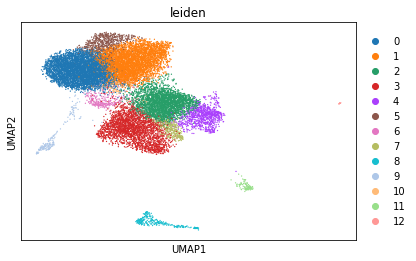

In [7]:
sc.pl.umap(adata, color=['leiden'])

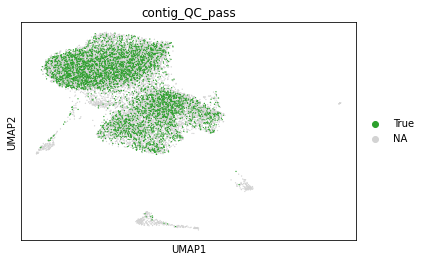

In [8]:
sc.pl.umap(adata, color=['contig_QC_pass'], groups = ['True'])

### Finding clones

In [9]:
ddl.tl.find_clones(vdj)

Finding clones based on VDJ chains : 100%|██████████| 242/242 [00:00<00:00, 922.58it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 4112/4112 [00:00<00:00, 341267.52it/s]


### Generate BCR network

In [10]:
ddl.tl.generate_network(vdj)

Linking edges : 100%|██████████| 4078/4078 [00:15<00:00, 268.87it/s]


generating network layout


### Transfer to `AnnData` and visualise

In [11]:
ddl.tl.transfer(adata, vdj, expanded_only = True)
adata

converting matrices
Updating anndata slots


AnnData object with n_obs × n_vars = 17684 × 865
    obs: 'sample_id', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'leiden', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'v_call_genotyped_VJ', 'd_call_VDJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ', 'duplicate_count_VJ', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_1', 'duplicate_count_VDJ_2', 'junction_aa_VDJ', 'junction_aa_VJ', 'locus_status', 'locus_status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'constant_status_summary'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'contig_QC_pass_colors', 'rna_neighbors'
    obsm: 'X_pca', 'X_umap', 'X_vdj'
    

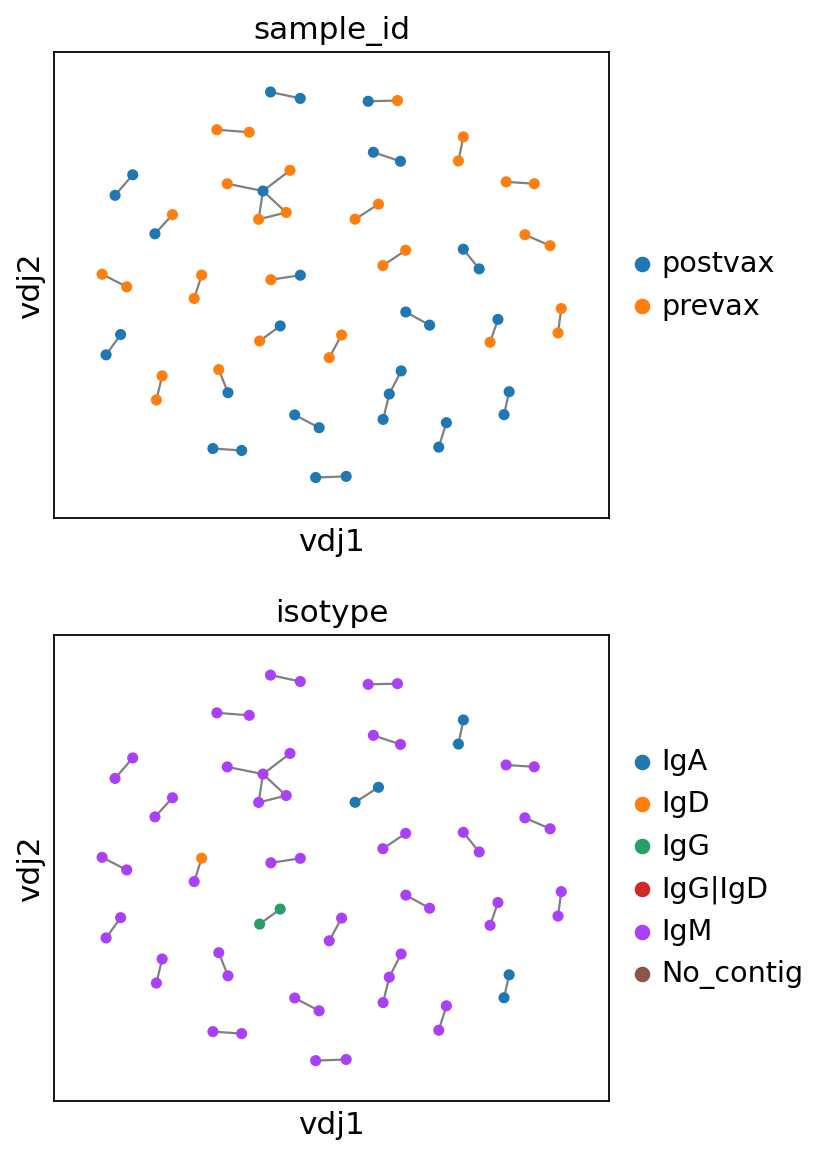

In [12]:
sc.set_figure_params(figsize = [4,4])
ddl.pl.clone_network(adata,
                     color = ['sample_id', 'isotype'],
                     edges_width = 1,
                     size = 100,
                     ncols = 1
                     )

For more in-depth tutorial and examples of the workflow, please visit `dandelion`'s [documentation](https://sc-dandelion.readthedocs.io/) and [github repository](https://github.com/zktuong/dandelion).